# 0.0 - Problema de Negócio

- Id: identificador único do cliente.
- Gender: gênero do cliente.
- Age: idade do cliente.
- Driving License: 0, o cliente não tem permissão para dirigir e 1, o cliente tem para dirigir ( CNH – Carteira Nacional de Habilitação )
- Region Code: código da região do cliente.
- Previously Insured: 0, o cliente não tem seguro de automóvel e 1, o cliente já tem seguro de automóvel.
- Vehicle Age: idade do veículo.
- Vehicle Damage: 0, cliente nunca teve seu veículo danificado no passado e 1, cliente já teve seu veículo danificado no passado.
- Anual Premium: quantidade que o cliente pagou à empresa pelo seguro de saúde anual.
- Policy sales channel: código anônimo para o canal de contato com o cliente.
- Vintage: número de dias que o cliente se associou à empresa através da compra do seguro de saúde.
- Response: 0, o cliente não tem interesse e 1, o cliente tem interesse.

# 1.0 - Importações e Funções

In [1]:
import pandas                  as pd
import seaborn                 as sns
import matplotlib.pyplot       as plt
import numpy                   as np
import scikitplot              as skplt

from IPython.display           import Image
from xgboost                   import XGBClassifier
from sklearn.tree              import DecisionTreeClassifier
from sklearn.dummy             import DummyClassifier
from sklearn.linear_model      import LogisticRegression
from sklearn.model_selection   import train_test_split, cross_validate, StratifiedKFold
from sklearn.ensemble          import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.metrics           import accuracy_score, precision_score, recall_score, average_precision_score, roc_auc_score
from sklearn.preprocessing     import RobustScaler, MinMaxScaler
from imblearn.under_sampling   import NearMiss
from sklearn.model_selection   import train_test_split

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Função para criar range de idades para visualizar melhor graficamente.
def age_range(age):
    if age < 31:
        return 1
    elif age >= 31 and age < 42:
        return 2
    elif age >= 42 and age < 53:
        return 3
    elif age >= 53 and age < 64:
        return 4
    elif age >= 64 and age < 75:
        return 5
    else: 
        return 6
        

In [3]:
# Função para criar range de valor pago para visualizar melhor graficamente.
def annual_premmium_range(valor):
    if valor < 100000:
        return 1
    elif valor >= 100000 and valor < 200000 :
        return 2
    elif valor >= 200000 and valor < 300000:
        return 3
    elif valor >= 300000 and valor < 400000:
        return 4
    elif valor >= 400000 and valor < 500000:
        return 5
    else: 
        return 6
        

# 2.0 -  Análise Descritiva 

In [5]:
df = pd.read_csv('train.csv')

In [6]:
df.sample(5)

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
256589,256590,Female,67,1,28.0,0,> 2 Years,Yes,52364.0,26.0,67,0
330193,330194,Male,39,1,28.0,0,1-2 Year,Yes,41963.0,124.0,233,0
149864,149865,Female,23,1,28.0,0,< 1 Year,Yes,41345.0,152.0,66,0
50370,50371,Male,46,1,46.0,0,1-2 Year,Yes,35858.0,91.0,212,1
160148,160149,Male,45,1,46.0,1,1-2 Year,No,2630.0,26.0,56,0


## 2.1 - Data Shape

In [7]:
df.shape

(381109, 12)

## 2.2 - Data Info

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 381109 entries, 0 to 381108
Data columns (total 12 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   id                    381109 non-null  int64  
 1   Gender                381109 non-null  object 
 2   Age                   381109 non-null  int64  
 3   Driving_License       381109 non-null  int64  
 4   Region_Code           381109 non-null  float64
 5   Previously_Insured    381109 non-null  int64  
 6   Vehicle_Age           381109 non-null  object 
 7   Vehicle_Damage        381109 non-null  object 
 8   Annual_Premium        381109 non-null  float64
 9   Policy_Sales_Channel  381109 non-null  float64
 10  Vintage               381109 non-null  int64  
 11  Response              381109 non-null  int64  
dtypes: float64(3), int64(6), object(3)
memory usage: 34.9+ MB


## 2.3 - Data Describe

In [9]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
id,381109.0,190555.000000,110016.836208,1.0,95278.0,190555.0,285832.0,381109.0
Age,381109.0,38.822584,15.511611,20.0,25.0,36.0,49.0,85.0
Driving_License,381109.0,0.997869,0.046110,0.0,1.0,1.0,1.0,1.0
Region_Code,381109.0,26.388807,13.229888,0.0,15.0,28.0,35.0,52.0
Previously_Insured,381109.0,0.458210,0.498251,0.0,0.0,0.0,1.0,1.0
Annual_Premium,381109.0,30564.389581,17213.155057,2630.0,24405.0,31669.0,39400.0,540165.0
Policy_Sales_Channel,381109.0,112.034295,54.203995,1.0,29.0,133.0,152.0,163.0
Vintage,381109.0,154.347397,83.671304,10.0,82.0,154.0,227.0,299.0
Response,381109.0,0.122563,0.327936,0.0,0.0,0.0,0.0,1.0


# 3.0 - Feature Enginnering 

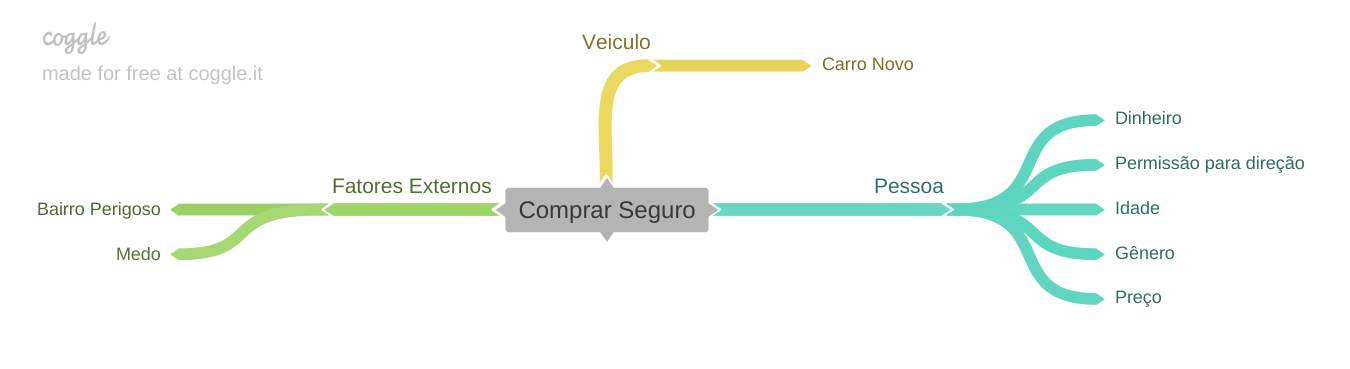

In [10]:
Image ('Comprar_Seguro.png')

## 3.1 - Criação das Hipóteses

**Hipótese do Veículo**

**1.** Clientes com carros mais novos tem mais propensão a comprar seguro.

**Hipótese da Pessoa**

**1.** Clientes que pagam um valor mais alto de seguro de vida tem mais propensão a comprar o seguro.<br/>
**2.** Clientes com mais idade tem mais propensão a comprar o seguro.<br/>
**3.** Homens tem mais propensão a comprar o seguro.<br/>
**4.** Clientes que tem carta de motorista tem mais propensão a comprar o seguro.<br/>
**5.** Cliente que já tiveram o carro danificado no passado tem mais propensão a comprar o seguro.

## 3.2 - Feature Engineering

In [11]:
df['DrivingLicense_PreviouslyInsured'] = df['Driving_License']+df['Previously_Insured']

df['Age_Range'] = df['Age'].apply(age_range)

df['Annual_Premium_range'] = df['Annual_Premium'].apply(annual_premmium_range)

## 3.3 Separação de variavéis númericas e categoricas

In [12]:
df_cat = df.select_dtypes(include='object')
df_num = df.select_dtypes(exclude='object')

# 4.0 - Análise Exploratória

## 4.1 - Análise univariada

### 4.1.1 - Variável Resposta

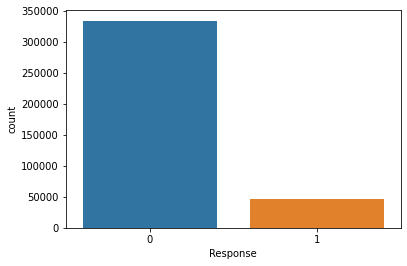

In [13]:
# Os dados estão desbalanceados. A grande maioria não tem interesse em efetuar a compra do seguro.
sns.countplot(x='Response', data=df);

### 4.1.2 - Variáveis númericas

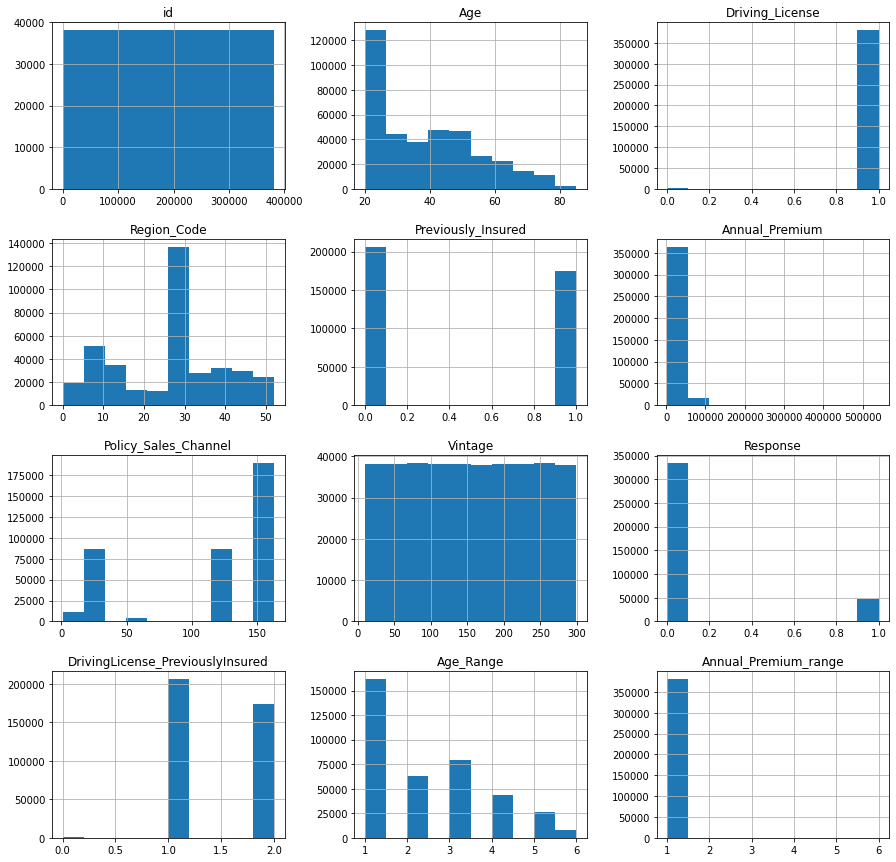

In [14]:
fig = plt.figure(figsize=(15,15))
ax = fig.gca()
df_num.hist(ax=ax);

### 4.1.3 - Variáveis Categoricas

In [15]:
df_cat.apply(lambda x: x.unique())

Gender                             [Male, Female]
Vehicle_Age       [> 2 Years, 1-2 Year, < 1 Year]
Vehicle_Damage                          [Yes, No]
dtype: object

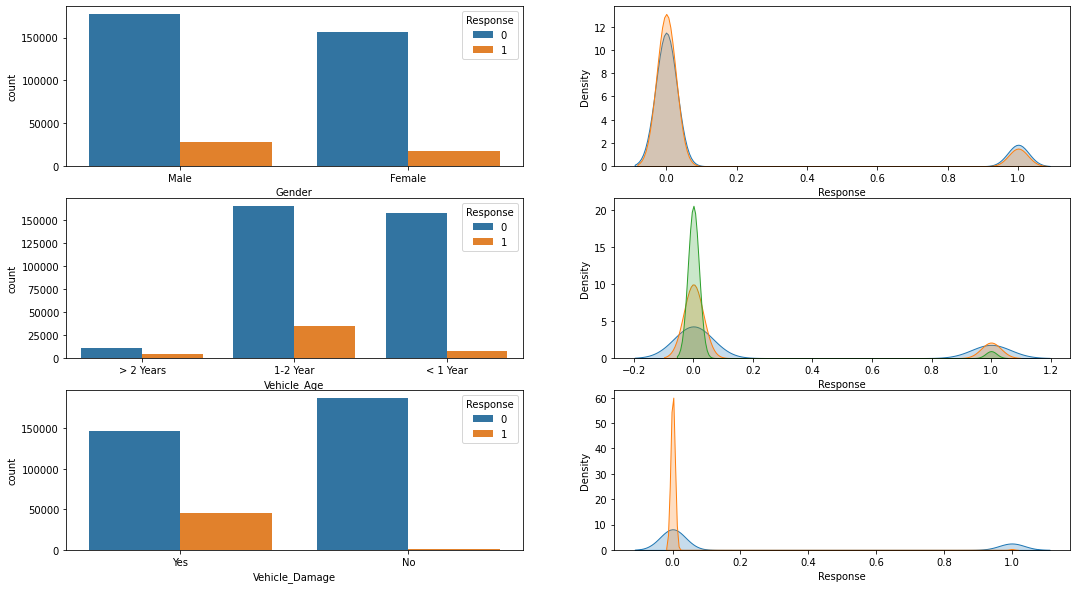

In [16]:
plt.figure(figsize=(18,10))
plt.subplot(3,2,1)
sns.countplot(x='Gender', hue='Response', data=df)

plt.subplot(3,2,2)
sns.kdeplot(df[df['Gender'] == 'Male']['Response'],label='Male', shade=True)
sns.kdeplot(df[df['Gender'] == 'Female']['Response'], label='Female', shade=True)

plt.subplot(3,2,3)
sns.countplot(x='Vehicle_Age', hue='Response', data=df)

plt.subplot(3,2,4)
sns.kdeplot(df[df['Vehicle_Age'] == '> 2 Years']['Response'],label='> 2 Years', shade=True)
sns.kdeplot(df[df['Vehicle_Age'] == '1-2 Year']['Response'], label='1-2 Year', shade=True)
sns.kdeplot(df[df['Vehicle_Age'] == '< 1 Year']['Response'], label='< 1 Year', shade=True)

plt.subplot(3,2,5)
sns.countplot(x='Vehicle_Damage', hue='Response', data=df)

plt.subplot(3,2,6)
sns.kdeplot(df[df['Vehicle_Damage'] == 'Yes']['Response'], label='Yes', shade=True)
sns.kdeplot(df[df['Vehicle_Damage'] == 'No']['Response'],  label='No', shade=True);

## 4.2 - Análise Bivariada

**H1 - Os clientes que possuem os carros mais novos são mais interessados em seguro?**

**R:** Falso. Em média os clientes que possuem carros com mais de dois anos tem mais interesse em comprar o seguro.

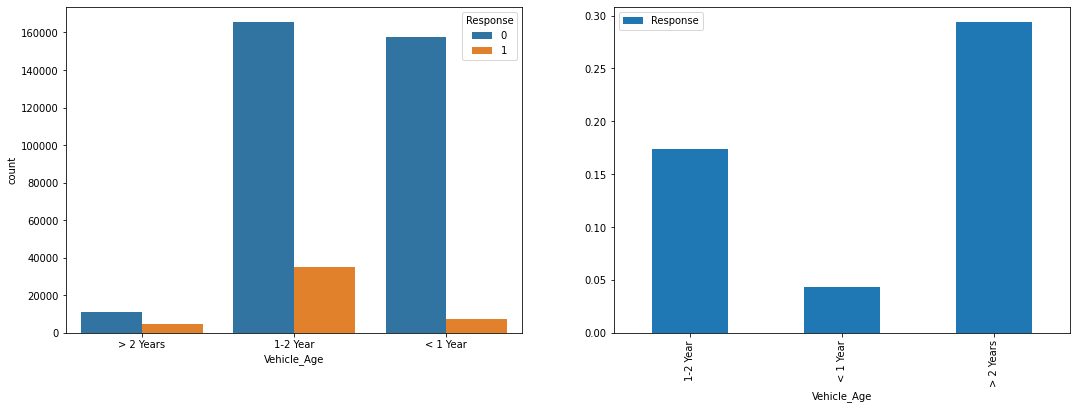

In [17]:
fig, ax = plt.subplots(1, 2, figsize=(18,6))

sns.countplot(x='Vehicle_Age', hue='Response', data=df, ax=ax[0]);

aux1 = df[['Vehicle_Age', 'Response']].groupby('Vehicle_Age').mean();
aux1.plot.bar(ax=ax[1]);


**H2 - Clientes que pagam um valor mais alto de seguro de vida tem mais propensão a comprar o seguro.**

**R:** Verdadeiro. Em média, clientes que pagam de 400 mil a 500 mil são os mais interessados em comprar o seguro.

ValueError: Cannot take a larger sample than population when 'replace=False'

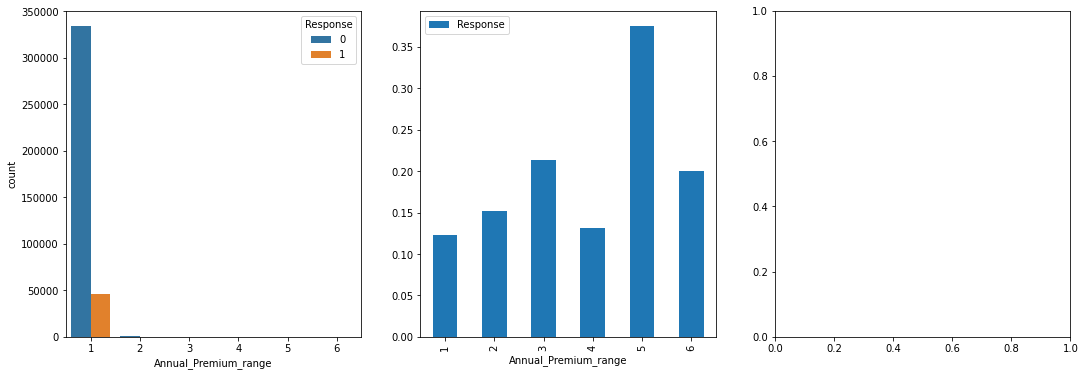

In [44]:
fig, ax = plt.subplots(1, 3, figsize=(18,6))
sns.countplot(x='Annual_Premium_range', hue='Response', data=df,ax=ax[0])

aux1 = df[['Annual_Premium_range', 'Response']].groupby('Annual_Premium_range').mean()
aux1.plot.bar(ax=ax[1]);

aux1 = aux1.sample(100000)
sns.scatterplot(x='Annual_Premium', y='id', hue='Response', data=aux1,ax=ax[2]);

**H3 - Clientes com mais idade tem mais propensão a comprar o seguro.**

**R:** Falso. Em média os clientes de meia idade tem mais interesse em comprar o seguro.

**Qual idade que contrata mais seguro?**

**R:** As pessoas mais jovens (até 30 anos)são mais acostumadas a contratar seguro.

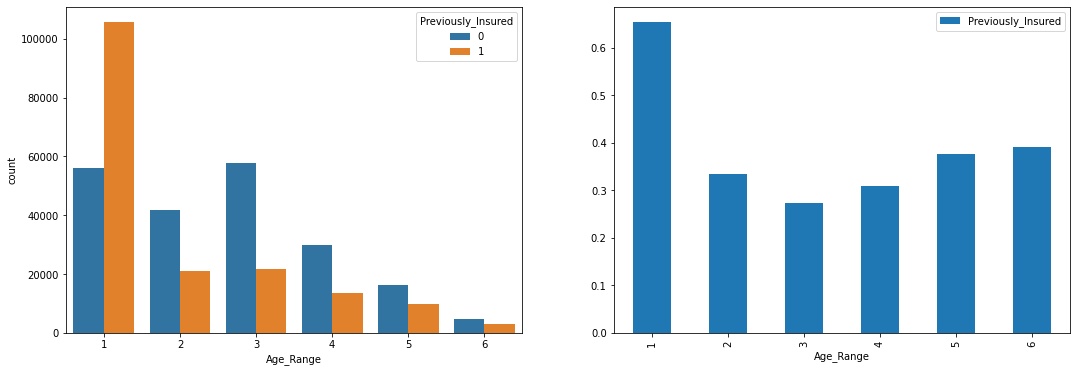

In [45]:
fig, ax = plt.subplots(1, 2, figsize=(18,6))

sns.countplot(x='Age_Range', hue='Previously_Insured', data=df, ax=ax[0]);

aux1 = df[['Age_Range', 'Previously_Insured']].groupby('Age_Range').mean();
aux1.plot.bar(ax=ax[1]);

**Qual idade está mais propensa a comprar o seguro?**

**R:** Em média, quem está no Age_Range 2 e 3 (de 31 até 53 anos) tem mais propensão a contratar um seguro.

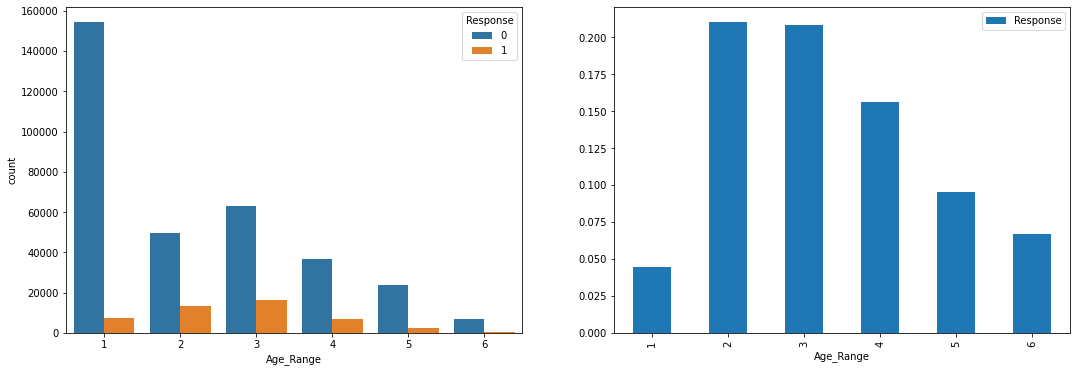

In [46]:
fig, ax = plt.subplots(1, 2, figsize=(18,6))

sns.countplot(x='Age_Range', hue='Response', data=df, ax=ax[0]);

aux1 = df[['Age_Range', 'Response']].groupby('Age_Range').mean()
aux1.plot.bar(ax=ax[1]);

**H4 - Homens tem mais propensão a comprar o seguro.**

**R:** Verdadeiro. Em média os clientes do gênero Masculino possuem interesse em comprar o seguro do que o gênero feminino.

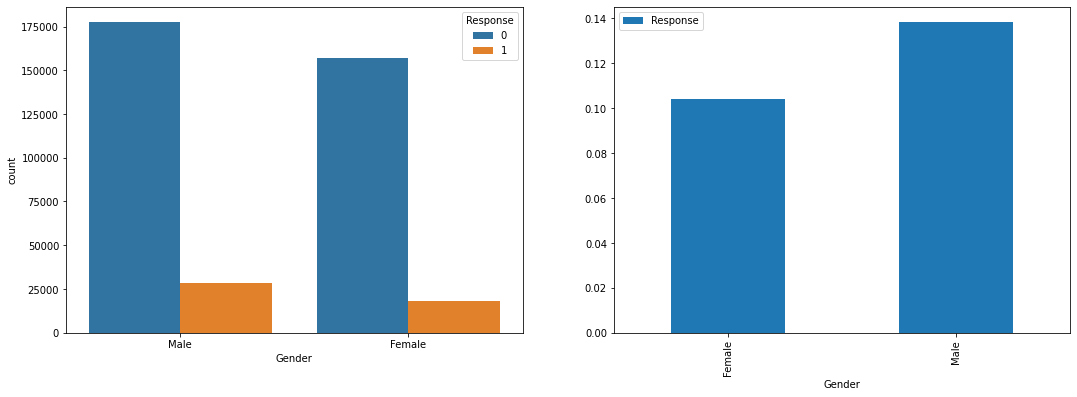

In [47]:
fig, ax = plt.subplots(1, 2, figsize=(18,6))

sns.countplot(x='Gender', hue='Response', data=df, ax=ax[0]);

aux1 = df[['Gender', 'Response']].groupby('Gender').mean();
aux1.plot.bar(ax=ax[1]);


**H5 - Clientes que tem carta de motorista tem mais propensão a comprar o seguro.**

**R:** Verdadeiro. A grande maioria das pessoas da amostra possui carteira de habilitação. Porém, é grande o número de pessoas que não possuem carta e tem interesse em contratar o seguro.

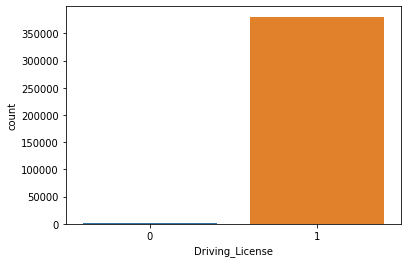

In [48]:
sns.countplot(x='Driving_License', data=df);

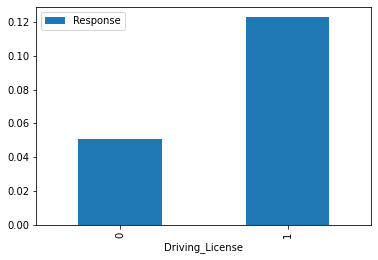

In [49]:
aux1 = df[['Driving_License', 'Response']].groupby('Driving_License').mean();
aux1.plot.bar();


**H6 - Cliente que já tiveram o carro danificado no passado tem mais propensão a comprar o seguro.**

**R:** Verdadeiro. Clientes que já sofreram acidentes contrataram muito mais o seguro.

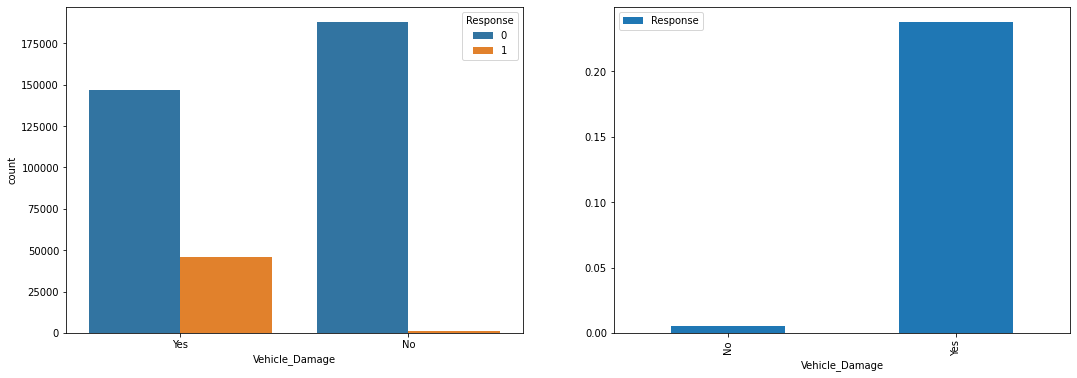

In [50]:
fig, ax = plt.subplots(1, 2, figsize=(18,6))

sns.countplot(x='Vehicle_Damage',hue='Response', data=df, ax=ax[0])

aux1=df[['Vehicle_Damage', 'Response']].groupby('Vehicle_Damage').mean();
aux1.plot.bar(ax=ax[1]);

 <h1>Mais Hipóteses<h1>

**Quem esta mais propenso a contratar? Quem já tem seguro ou quem ainda não tem?**

**R:** Aparentemente as pessoas que ainda não tem seguro são mais interessadas em contratar do que as pessoas que já tem.

- A porcentagem de pessoas que não tem seguro e contratariam seguro  é 23%
- A porcentagem de pessoas que ja tem seguro e contratariam outro é 0.09%

O total de pessoas que já tem seguro e não estariam interessadas em contratar outro seguro é:  174470
O total de pessoas que já tem seguro e estariam interessadas interessadas em contratar outro seguro é:  158
-----------------------------------------------------------------------------
O total de pessoas que não tem seguro e não estariam interessada em ter seguro é:  159929
O total de pessoas que não tem seguro e estariam interessadas em contratar seguro é:  46552
-----------------------------------------------------------------------------


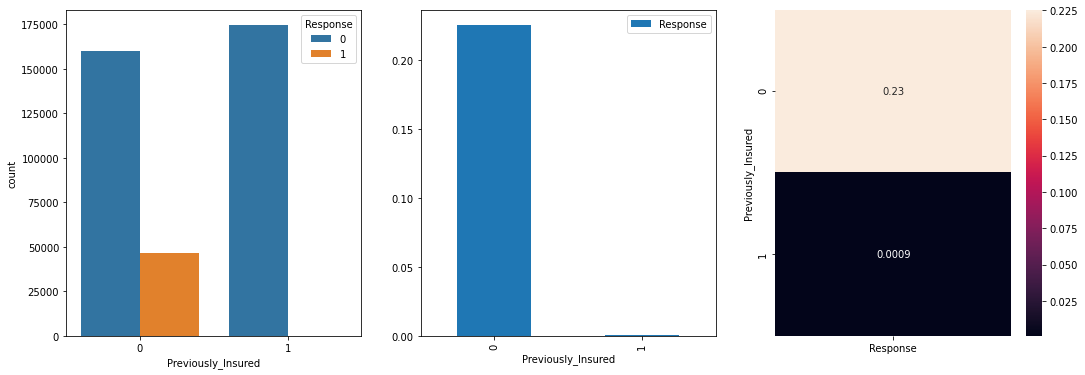

In [51]:
fig, ax = plt.subplots(1, 3, figsize=(18,6))

sns.countplot(x='Previously_Insured', hue='Response', data=df, ax=ax[0]);

print("O total de pessoas que já tem seguro e não estariam interessadas em contratar outro seguro é: ",
df[(df['Previously_Insured']==1) & (df['Response']==0)].shape[0])

print("O total de pessoas que já tem seguro e estariam interessadas interessadas em contratar outro seguro é: ",
df[(df['Previously_Insured']==1) & (df['Response']==1)].shape[0])

print("-----------------------------------------------------------------------------")

print("O total de pessoas que não tem seguro e não estariam interessada em ter seguro é: ",
df[(df['Previously_Insured']==0) & (df['Response']==0)].shape[0])

print("O total de pessoas que não tem seguro e estariam interessadas em contratar seguro é: ",
df[(df['Previously_Insured']==0) & (df['Response']==1)].shape[0])

print("-----------------------------------------------------------------------------")

aux1 = df[['Previously_Insured', 'Response']].groupby('Previously_Insured').mean();
aux1.plot.bar(ax=ax[1]);

sns.heatmap(aux1, annot=True, ax=ax[2]);

**Qual região possui mais clientes em nossa amostra?**

**R:** A Região 28 é a região que mais possui clientes em nossa amostra.

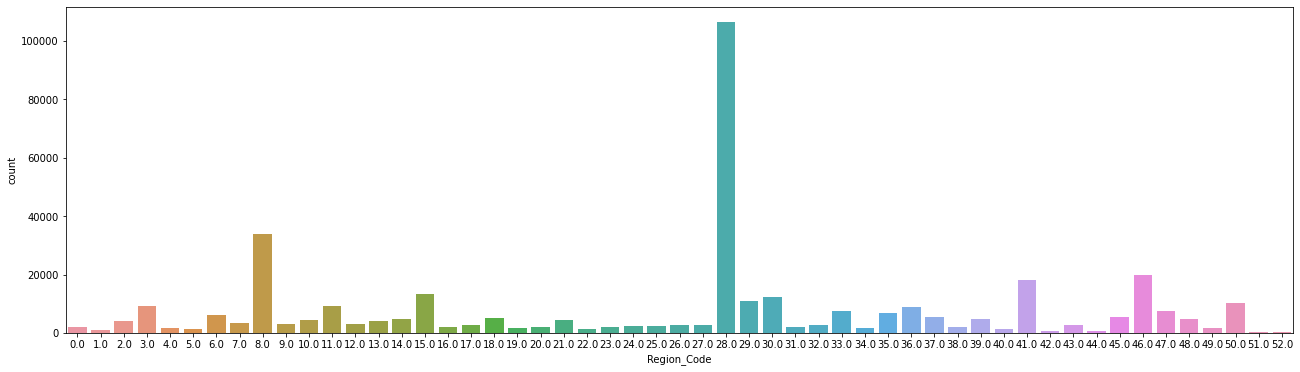

In [52]:
plt.figure(figsize=(22,6))
sns.countplot(x='Region_Code', data=df);

## 4.3 - Análise Multivariada

### Variavéis Númericas

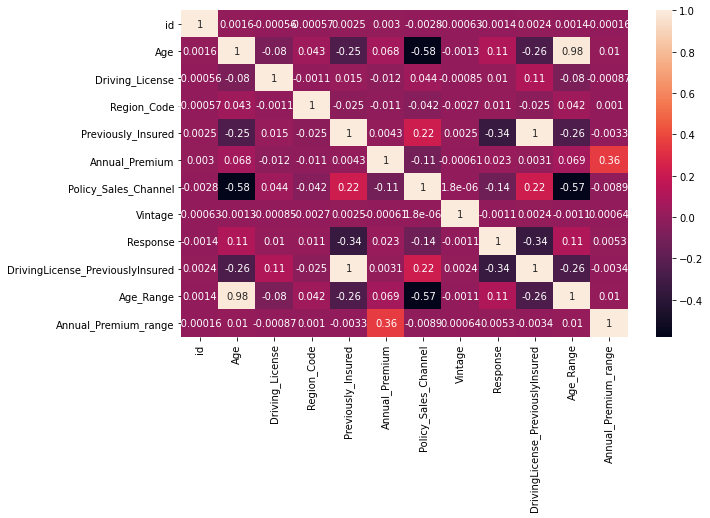

In [53]:
correlation = df_num.corr(method='pearson')
plt.figure(figsize=(10,6))
sns.heatmap(correlation, annot=True);

# 5.0 - Preparação dos Dados

## 5.2 - Dummização das variavéis categoricas

In [54]:
df_cat = pd.get_dummies(df_cat, drop_first=True)

In [55]:
df_2 = pd.concat([df_cat, df_num], axis=1)
df_2.head()

,Gender_Male,Vehicle_Age_< 1 Year,Vehicle_Age_> 2 Years,Vehicle_Damage_Yes,id,Age,Driving_License,Region_Code,Previously_Insured,Annual_Premium,Policy_Sales_Channel,Vintage,Response,DrivingLicense_PreviouslyInsured,Age_Range,Annual_Premium_range
0,1,0,1,1,1,44,1,28.0,0,40454.0,26.0,217,1,1,3,1
1,1,0,0,0,2,76,1,3.0,0,33536.0,26.0,183,0,1,6,1
2,1,0,1,1,3,47,1,28.0,0,38294.0,26.0,27,1,1,3,1
3,1,1,0,0,4,21,1,11.0,1,28619.0,152.0,203,0,2,1,1
4,0,1,0,0,5,29,1,41.0,1,27496.0,152.0,39,0,2,1,1


## 5.3 - Normalização

### Criando objeto

In [56]:
mm = MinMaxScaler()
rb = RobustScaler()

### Normalização

In [57]:
df_2['Age'] = mm.fit_transform(df_2[['Age']].values)

df_2['Region_Code'] = mm.fit_transform(df_2[['Region_Code']].values)

df_2['Annual_Premium'] = rb.fit_transform(df_2[['Annual_Premium']].values)

df_2['Policy_Sales_Channel'] = mm.fit_transform(df_2[['Policy_Sales_Channel']].values)

df_2['Vintage'] = mm.fit_transform(df_2[['Vintage']].values)

In [58]:
X = df_2.drop(['Response'], axis=1)
y = df_2['Response']

In [59]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

### Feature Importance

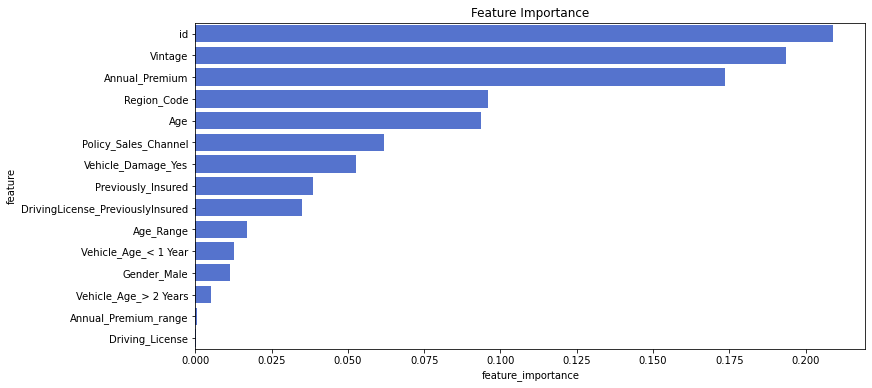

In [60]:
# train random forest classifier
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)

# feature importance data frame
feat_imp = pd.DataFrame({'feature': X_train.columns,
                        'feature_importance': rf.feature_importances_})\
                        .sort_values('feature_importance', ascending=False)\
                        .reset_index(drop=True)


# plot feature importance
plt.subplots(figsize=(12,6))
sns.barplot(x='feature_importance', y='feature', data=feat_imp, orient='h', color='royalblue')\
    .set_title('Feature Importance');

In [142]:
X_train = X_train[['Vintage', 'Annual_Premium', 'Region_Code', 'Age', 
             'Previously_Insured', 'Vehicle_Damage_Yes' ]]

X_test = X_test[['Vintage', 'Annual_Premium', 'Region_Code', 'Age', 
             'Previously_Insured', 'Vehicle_Damage_Yes' ]]

# 6.0 - Machine Learning

In [64]:
du = DummyClassifier()
lr = LogisticRegression()
dtc = DecisionTreeClassifier()
etx = ExtraTreesClassifier()
rfc = RandomForestClassifier()
gbc = GradientBoostingClassifier()
xbc = XGBClassifier()

In [190]:
du.fit(X_train, y_train)

DummyClassifier()

In [191]:
y_pred_du = du.predict_proba(X_test)

<AxesSubplot:title={'center':'Cumulative Gains Curve'}, xlabel='Percentage of sample', ylabel='Gain'>

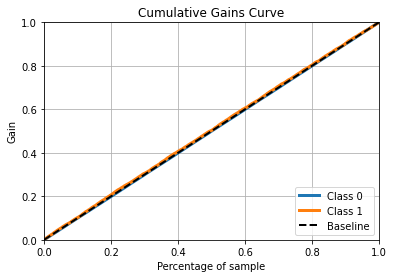

In [192]:
skplt.metrics.plot_cumulative_gain(y_test, y_pred_du)

In [193]:
lr.fit(X_train, y_train)

LogisticRegression()

In [194]:
y_pred_lr = lr.predict_proba(X_test)

<AxesSubplot:title={'center':'Cumulative Gains Curve'}, xlabel='Percentage of sample', ylabel='Gain'>

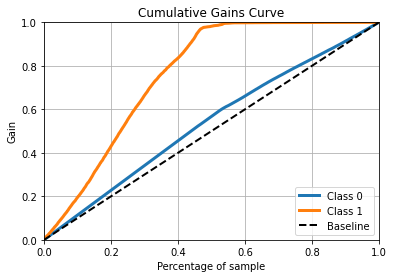

In [195]:
skplt.metrics.plot_cumulative_gain(y_test, y_pred_lr)

In [197]:
dtc.fit(X_train, y_train)

DecisionTreeClassifier()

In [201]:
y_pred_dtc = dtc.predict_proba(X_test)

<AxesSubplot:title={'center':'Cumulative Gains Curve'}, xlabel='Percentage of sample', ylabel='Gain'>

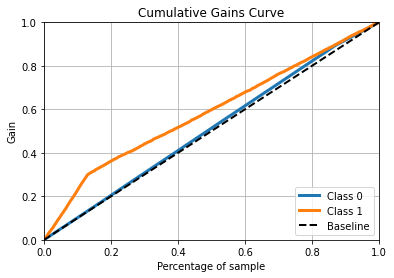

In [206]:
skplt.metrics.plot_cumulative_gain(y_test, y_pred_dtc)

In [198]:
etx.fit(X_train, y_train)

ExtraTreesClassifier()

In [202]:
y_pred_etx = etx.predict_proba(X_test)

<AxesSubplot:title={'center':'Cumulative Gains Curve'}, xlabel='Percentage of sample', ylabel='Gain'>

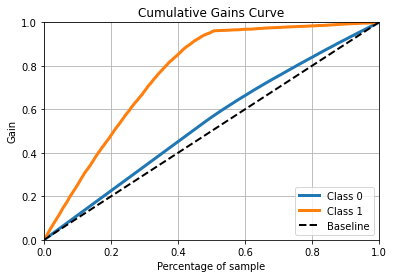

In [207]:
skplt.metrics.plot_cumulative_gain(y_test, y_pred_etx)

In [199]:
rfc.fit(X_train, y_train)

RandomForestClassifier()

In [203]:
y_pred_rfc = rfc.predict_proba(X_test)

<AxesSubplot:title={'center':'Cumulative Gains Curve'}, xlabel='Percentage of sample', ylabel='Gain'>

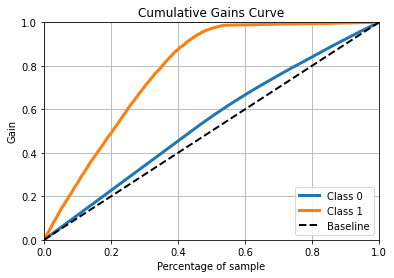

In [208]:
skplt.metrics.plot_cumulative_gain(y_test, y_pred_rfc)

In [200]:
gbc.fit(X_train, y_train)

GradientBoostingClassifier()

In [204]:
y_pred_gbc = gbc.predict_proba(X_test)

<AxesSubplot:title={'center':'Cumulative Gains Curve'}, xlabel='Percentage of sample', ylabel='Gain'>

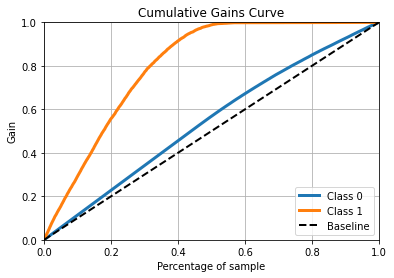

In [209]:
skplt.metrics.plot_cumulative_gain(y_test, y_pred_gbc)

In [196]:
xbc.fit(X_train, y_train)

[20:07:09] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=4, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [205]:
y_pred_xbc = xbc.predict_proba(X_test)

<AxesSubplot:title={'center':'Cumulative Gains Curve'}, xlabel='Percentage of sample', ylabel='Gain'>

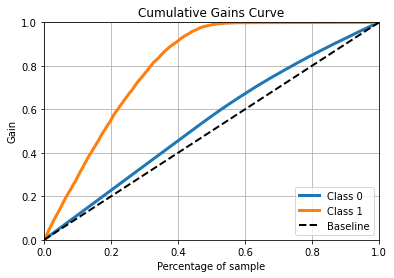

In [210]:
skplt.metrics.plot_cumulative_gain(y_test, y_pred_xbc)

In [ ]:
pip freeze > requirements.txt